In [ ]:
from __future__ import annotations
import re
import warnings
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Sequence, Tuple
import numpy as np
import pandas as pd
import xarray as xr
from IPython.display import display
import math
import matplotlib.pyplot as plt


# 1. Import Dependencies and Configure Notebook Environment
This notebook gathers helper utilities for inspecting raw SWOT granules so we can compare ascending and descending passes.

In [21]:
"""Utility imports and notebook-wide options."""



                                                                
warnings.filterwarnings("ignore", message=".*invalid value encountered.*")

NOTEBOOK_ROOT = Path.cwd().resolve()
PROJECT_ROOT = NOTEBOOK_ROOT.parent
DATA_SOURCES_ROOT = PROJECT_ROOT / "data" / "sources" / "swot"
print(f"Project root: {PROJECT_ROOT}")
print(f"Default SWOT source: {DATA_SOURCES_ROOT}")

Project root: /Users/mako3626/newfrontiers/poseidon
Default SWOT source: /Users/mako3626/newfrontiers/poseidon/data/sources/swot


# 2. Parameterize Cycle and Pass Targets
Define reusable helpers so we can point to specific cycle/pass combinations once the raw data location is confirmed.

In [22]:
"""Cycle/pass configuration and helper utilities."""
RAW_DATA_ROOT = DATA_SOURCES_ROOT
FILE_EXTENSIONS: Tuple[str, ...] = (".nc", ".nc4", ".nc.gz", ".nc4.gz")

CYCLE_PASS_TARGETS: Dict[int, Sequence[int]] = {
    20: (173, 203),
    21: (173, 203),
}

CYCLE_PASS_PATTERNS: Dict[Tuple[int, int], Sequence[str]] = {
    (20, 173): ("*_020_173_*.nc*", "*_020_173_*.nc4*"),
    (20, 203): ("*_020_203_*.nc*", "*_020_203_*.nc4*"),
    (21, 173): ("*_021_173_*.nc*", "*_021_173_*.nc4*"),
    (21, 203): ("*_021_203_*.nc*", "*_021_203_*.nc4*"),
}

dataset_registry: Dict[Tuple[int, int], Optional[xr.Dataset]] = {}
path_registry: Dict[Tuple[int, int], List[Path]] = {}


def has_valid_extension(path: Path) -> bool:
    """Return True when *path* ends with one of the allowed extensions."""
    name = str(path)
    return any(name.endswith(ext) for ext in FILE_EXTENSIONS)


def iter_targets() -> Iterable[Tuple[int, int]]:
    for cycle, passes in CYCLE_PASS_TARGETS.items():
        for pas in passes:
            yield cycle, pas


def find_granule_paths(cycle: int, pas: int, root: Path = RAW_DATA_ROOT) -> List[Path]:
    """Return sorted candidate files for a given cycle/pass under *root*."""
    if not root.exists():
        print(f"RAW_DATA_ROOT does not exist: {root}")
        return []

    patterns = CYCLE_PASS_PATTERNS.get((cycle, pas))
    if patterns is None:
        patterns = (f"*_{cycle:03d}_{pas:03d}_*", f"*_{cycle:03d}_{pas:03d}.*")

    matches: List[Path] = []
    for pattern in patterns:
        for candidate in root.rglob(pattern):
            if not candidate.is_file():
                continue
            if not has_valid_extension(candidate):
                continue
            matches.append(candidate.resolve())

    unique_paths = sorted(dict.fromkeys(matches))                                       
    if not unique_paths:
        print(f"No granules matched patterns {patterns} under {root}")
    else:
        print(f"Found {len(unique_paths)} granules for cycle {cycle}, pass {pas}")
    path_registry[(cycle, pas)] = list(unique_paths)
    return list(unique_paths)


def load_swot_dataset(path: Path) -> xr.Dataset:
    """Open a SWOT granule with xarray for exploration."""
    if str(path).endswith(".gz"):
        return xr.open_dataset(path, engine="netcdf4")
    return xr.open_dataset(path)


def load_pass_dataset(cycle: int, pas: int, *, cache: bool = True) -> Optional[xr.Dataset]:
    """Load a dataset for the given cycle/pass, caching the handle for reuse."""
    key = (cycle, pas)
    if cache and key in dataset_registry:
        return dataset_registry[key]

    candidates = find_granule_paths(cycle, pas)
    if not candidates:
        dataset_registry[key] = None
        return None

    ds = load_swot_dataset(candidates[0])
    dataset_registry[key] = ds
    return ds


def summarize_dataset(ds: xr.Dataset, *, max_variables: int = 10) -> None:
    """Print a lightweight summary of an xarray.Dataset."""
    print("Dimensions:", ds.dims)
    data_vars = list(ds.data_vars)
    print("Data variables (first %d): %s" % (max_variables, data_vars[:max_variables]))
    coord_vars = list(ds.coords)
    print("Coordinates:", coord_vars)
    if "time" in ds:
        time_da = ds["time"]
        print("Time range:", str(time_da.min().values), "->", str(time_da.max().values))
    print("Attributes keys:", list(ds.attrs.keys()))


def inspect_pass_dataset(cycle: int, pas: int, *, preview_rows: int = 5) -> Optional[xr.Dataset]:
    """Load, summarize, and preview a cycle/pass dataset."""
    ds = load_pass_dataset(cycle, pas)
    if ds is None:
        return None

    print(f"\n=== Cycle {cycle}, Pass {pas} ===")
    summarize_dataset(ds)

                                                     
    try:
        df_preview = ds.to_dataframe().reset_index().head(preview_rows)
        display(df_preview)
    except Exception as exc:                                            
        print(f"Preview unavailable: {exc}")
    return ds

# 3. Load Raw Data for Cycle 20 Pass 173
Trigger the loader in exploration mode to locate and open the target granule once the path mapping is set.

# 3. Load Raw Data for Cycle 20 Pass 173
Trigger the loader in exploration mode to locate and open the target granule once the path mapping is set.

In [62]:
cycle_20_pass_173 = inspect_pass_dataset(20, 188, preview_rows=8)

Found 1 granules for cycle 20, pass 188

=== Cycle 20, Pass 188 ===
Dimensions: FrozenMappingWarningOnValuesAccess({'num_lines': 9866, 'num_pixels': 69, 'num_sides': 2})
Data variables (first 10): ['time', 'time_tai', 'ssh_karin', 'ssh_karin_qual', 'ssh_karin_uncert', 'ssha_karin', 'ssha_karin_qual', 'ssh_karin_2', 'ssh_karin_2_qual', 'ssha_karin_2']
Coordinates: ['latitude', 'longitude', 'latitude_nadir', 'longitude_nadir']
Time range: 2024-08-27T08:10:52.096588928 -> 2024-08-27T09:02:20.231369216
Attributes keys: ['Conventions', 'title', 'institution', 'source', 'history', 'platform', 'reference_document', 'contact', 'cycle_number', 'pass_number', 'equator_time', 'short_name', 'product_file_id', 'crid', 'product_version', 'pge_name', 'pge_version', 'time_coverage_start', 'time_coverage_end', 'geospatial_lon_min', 'geospatial_lon_max', 'geospatial_lat_min', 'geospatial_lat_max', 'left_first_longitude', 'left_first_latitude', 'left_last_longitude', 'left_last_latitude', 'right_first_lo

,num_lines,num_pixels,num_sides,time,time_tai,latitude,longitude,ssh_karin,ssh_karin_qual,ssh_karin_uncert,...,rain_rate,ice_conc,sea_state_bias_cor,sea_state_bias_cor_2,swh_ssb_cor_source,swh_ssb_cor_source_2,wind_speed_ssb_cor_source,wind_speed_ssb_cor_source_2,volumetric_correlation,volumetric_correlation_uncert
0,0,0,0,2024-08-27 08:10:52.096588928,2024-08-27 08:11:29.096588672,78.272006,195.712444,NaN,3.892347e+09,NaN,...,0.0,34.87,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0,0,1,2024-08-27 08:10:52.096588928,2024-08-27 08:11:29.096588672,78.272006,195.712444,NaN,3.892347e+09,NaN,...,0.0,34.87,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,0,1,0,2024-08-27 08:10:52.096588928,2024-08-27 08:11:29.096588672,78.254093,195.712733,2.1491,3.356132e+09,0.0140,...,0.0,34.82,0.0,0.0,0.0,0.0,0.0,4.0,0.9903,0.08
3,0,1,1,2024-08-27 08:10:52.096588928,2024-08-27 08:11:29.096588672,78.254093,195.712733,2.1491,3.356132e+09,0.0140,...,0.0,34.82,0.0,0.0,0.0,0.0,0.0,4.0,0.9903,0.08
4,0,2,0,2024-08-27 08:10:52.096588928,2024-08-27 08:11:29.096588672,78.236179,195.713020,2.1402,3.356132e+09,0.0066,...,0.0,34.84,0.0,0.0,0.0,0.0,0.0,4.0,0.9942,0.04
5,0,2,1,2024-08-27 08:10:52.096588928,2024-08-27 08:11:29.096588672,78.236179,195.713020,2.1402,3.356132e+09,0.0066,...,0.0,34.84,0.0,0.0,0.0,0.0,0.0,4.0,0.9942,0.04
6,0,3,0,2024-08-27 08:10:52.096588928,2024-08-27 08:11:29.096588672,78.218266,195.713307,2.1381,3.356131e+09,0.0036,...,0.0,35.00,0.0,0.0,0.0,0.0,0.0,4.0,0.9977,0.04
7,0,3,1,2024-08-27 08:10:52.096588928,2024-08-27 08:11:29.096588672,78.218266,195.713307,2.1381,3.356131e+09,0.0036,...,0.0,35.00,0.0,0.0,0.0,0.0,0.0,4.0,0.9977,0.04


In [ ]:
                                                                                         
bbox = {"min_lon": -99, "min_lat": 17, "max_lon": -79, "max_lat": 31}

def subset_ds_to_bbox(ds: xr.Dataset, bbox: dict) -> xr.Dataset:
    if ds is None:
        print("No dataset provided.")
        return ds

    lat = ds["latitude"]
    lon = ds["longitude"]

                                                           
    lon_min_ds = float(lon.min().values)
    lon_max_ds = float(lon.max().values)
    print(f"Dataset lon range: {lon_min_ds:.3f} -> {lon_max_ds:.3f}")

                                                
    bb = bbox.copy()

    if lon_min_ds >= 0 and (bb["min_lon"] < -180 or bb["max_lon"] < 0):
        bb["min_lon"] = bb["min_lon"] % 360
        bb["max_lon"] = bb["max_lon"] % 360
        print(f"Converted bbox lon to 0-360: {bb['min_lon']} -> {bb['max_lon']}")

    lat_mask = (lat >= bb["min_lat"]) & (lat <= bb["max_lat"])

    if bb["min_lon"] <= bb["max_lon"]:
        lon_mask = (lon >= bb["min_lon"]) & (lon <= bb["max_lon"])
    else:
        lon_mask = (lon >= bb["min_lon"]) | (lon <= bb["max_lon"])

    mask = lat_mask & lon_mask

    ds_sub = ds.where(mask, drop=True)
    print("Subset dims:", ds_sub.dims)
    return ds_sub

ds_bbox = subset_ds_to_bbox(cycle_20_pass_173, bbox)
if ds_bbox is not None:
    df_bbox = ds_bbox.to_dataframe().reset_index().dropna(subset=["latitude", "longitude"])
    print("Rows in bbox dataframe:", len(df_bbox))
    display(df_bbox.head())


Dataset lon range: 0.000 -> 359.999
Converted bbox lon to 0-360: 261 -> 281
Subset dims: FrozenMappingWarningOnValuesAccess({'num_lines': 800, 'num_pixels': 69, 'num_sides': 2})
Rows in bbox dataframe: 110400


,num_lines,num_pixels,num_sides,time,time_tai,ssh_karin,ssh_karin_qual,ssh_karin_uncert,ssha_karin,ssha_karin_qual,...,swh_ssb_cor_source,swh_ssb_cor_source_2,wind_speed_ssb_cor_source,wind_speed_ssb_cor_source_2,volumetric_correlation,volumetric_correlation_uncert,latitude,longitude,latitude_nadir,longitude_nadir
0,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,31.230471,274.834572,31.116223,274.141046
1,0,0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,31.230471,274.834572,31.116223,274.141046
2,0,1,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,31.227125,274.813944,31.116223,274.141046
3,0,1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,31.227125,274.813944,31.116223,274.141046
4,0,2,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,31.223776,274.793318,31.116223,274.141046


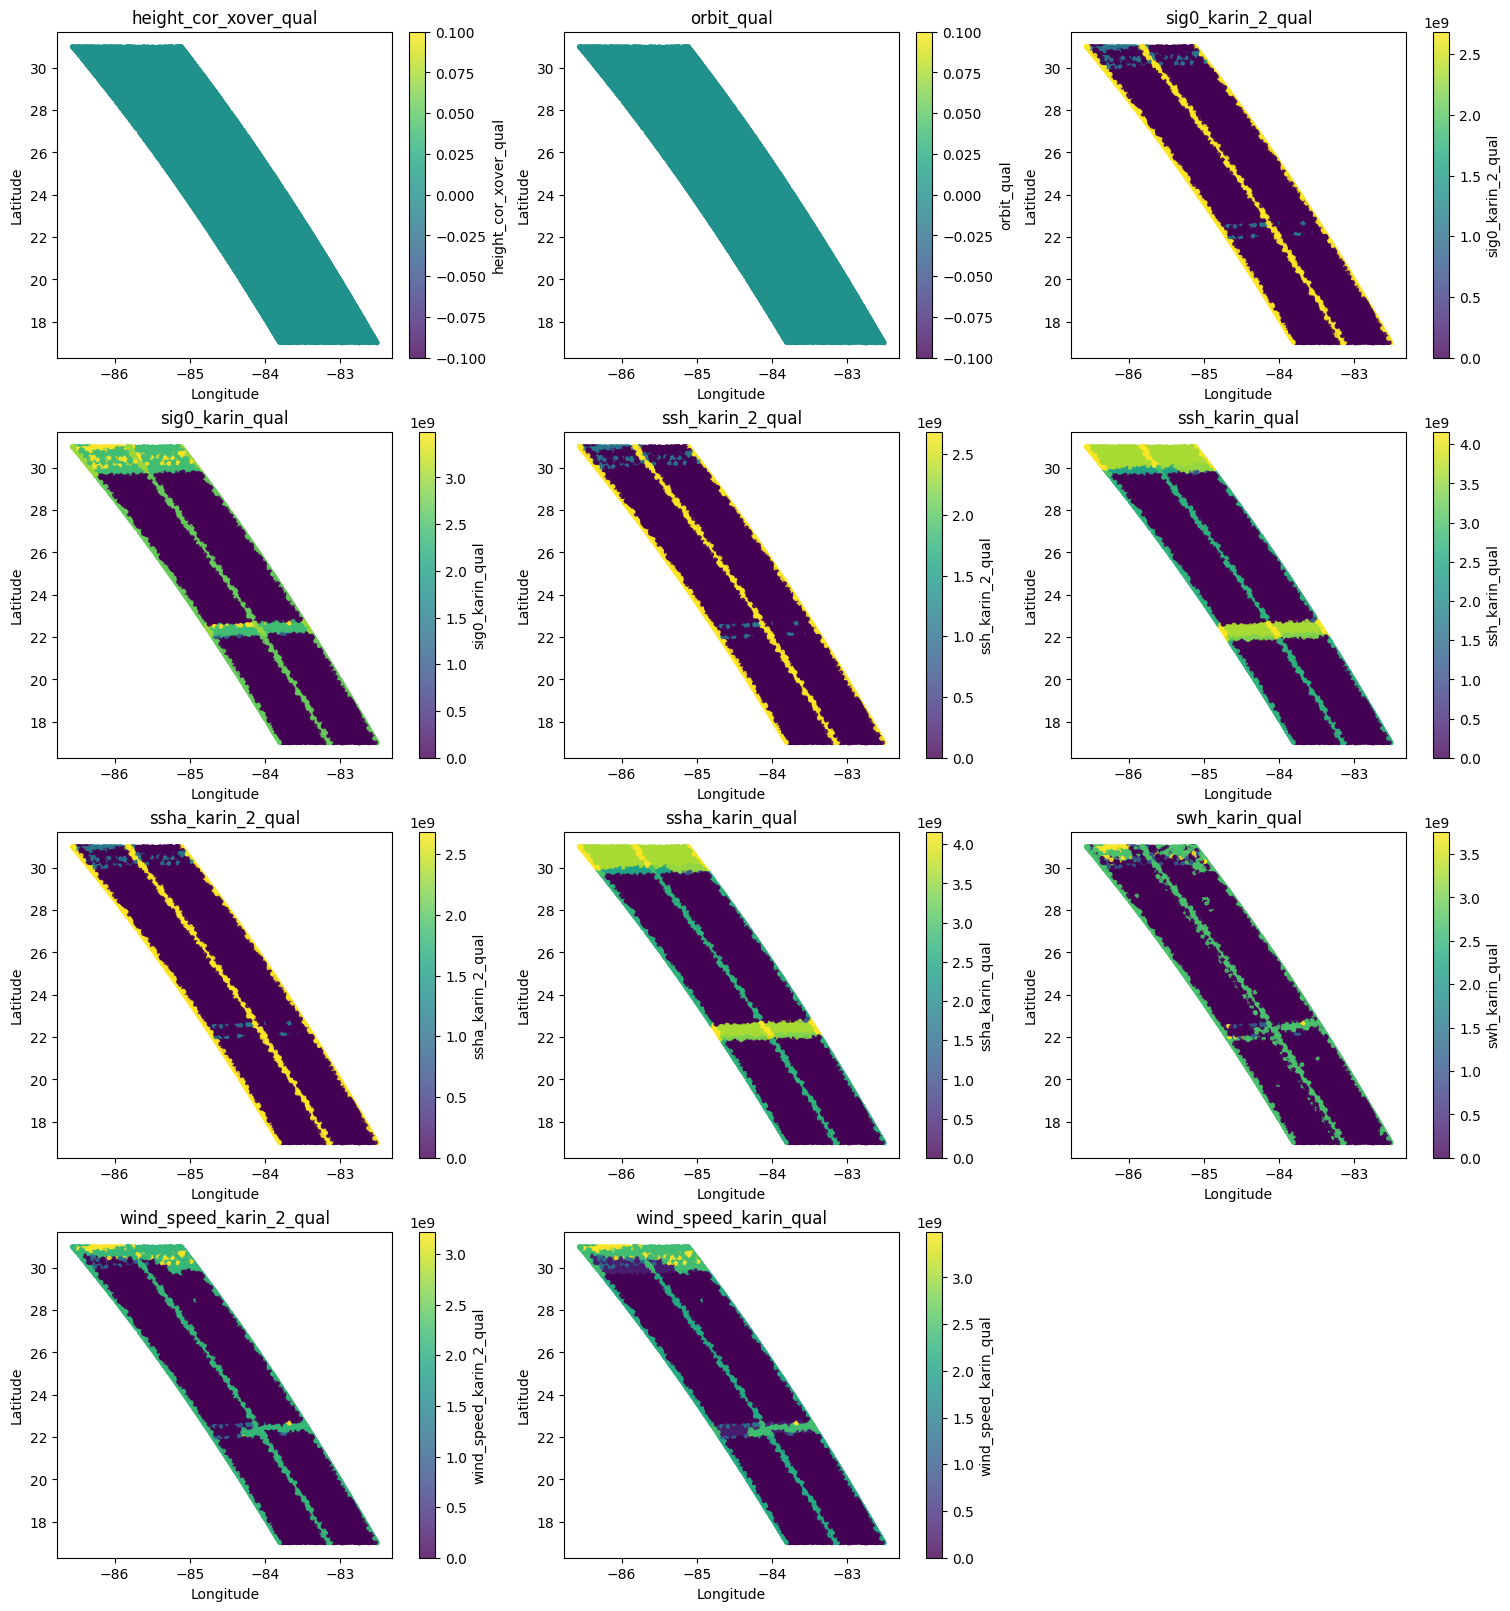

In [ ]:

qual_vars_found = sorted({c for c in df_bbox.columns if c.endswith("_qual") or "_qual" in c})
if not qual_vars_found:
    raise RuntimeError("No _qual variables found in df_bbox")


vars_to_plot = [v for v in qual_vars_found if v in df_bbox.columns]
if not vars_to_plot:
    raise RuntimeError("No _qual variables found in df_bbox")


df_plot = df_bbox.copy()
df_plot["plot_lon"] = np.where(df_plot["longitude"] > 180, df_plot["longitude"] - 360, df_plot["longitude"])

n = len(vars_to_plot)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), constrained_layout=True)
axes = axes.ravel()

for ax, name in zip(axes, vars_to_plot):
    sub = df_plot.dropna(subset=["latitude", "plot_lon", name])
    if sub.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])
        continue


    max_points = 50000
    if len(sub) > max_points:
        sub = sub.sample(max_points, random_state=0)

    sc = ax.scatter(sub["plot_lon"], sub["latitude"], c=sub[name], s=6, cmap="viridis", alpha=0.8)
    ax.set_title(name)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.colorbar(sc, ax=ax, label=name)

                          
for ax in axes[len(vars_to_plot):]:
    ax.axis("off")

plt.show()

In [ ]:

qual_vars_found = sorted({c for c in df_bbox.columns if c.endswith("_qual") or "xover" in c})
if not qual_vars_found:
    raise RuntimeError("No _qual variables found in df_bbox")

In [66]:
qual_vars_found

['height_cor_xover',
 'height_cor_xover_qual',
 'orbit_qual',
 'sig0_karin_2_qual',
 'sig0_karin_qual',
 'ssh_karin_2_qual',
 'ssh_karin_qual',
 'ssha_karin_2_qual',
 'ssha_karin_qual',
 'swh_karin_qual',
 'wind_speed_karin_2_qual',
 'wind_speed_karin_qual']

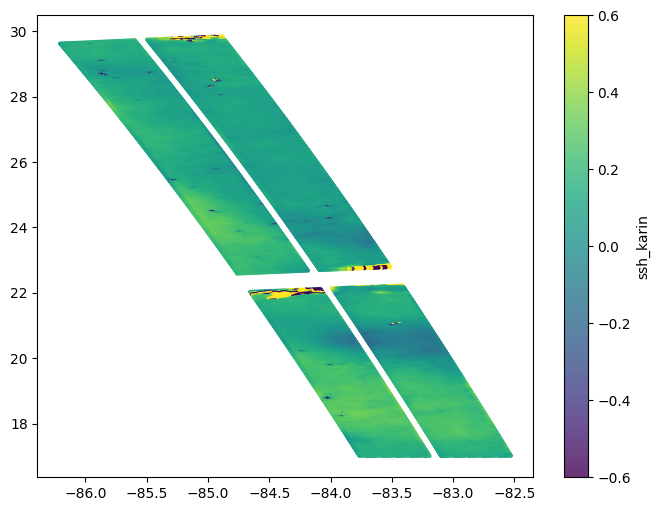

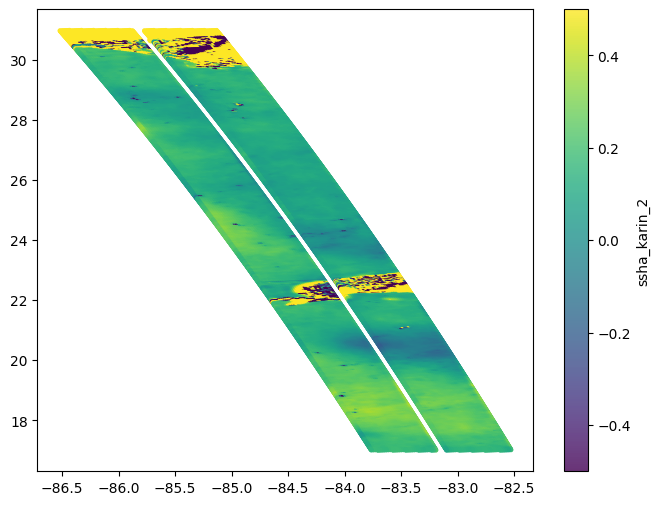

In [69]:
df_plot = df_bbox.copy()
df_plot["plot_lon"] = np.where(df_plot["longitude"] > 180, df_plot["longitude"] - 360, df_plot["longitude"])

plt.figure(figsize=(8, 6))
sc = plt.scatter(df_plot["plot_lon"], df_plot["latitude"], c=df_plot["ssha_karin"] + df_plot["height_cor_xover"], s=3, cmap="viridis", alpha=0.8,vmin=-0.6,vmax=0.6)
plt.colorbar(sc, label="ssh_karin")
plt.show()

plt.figure  (figsize=(8, 6))
sc = plt.scatter(df_plot["plot_lon"], df_plot["latitude"], c=df_plot["ssha_karin_2"] + df_plot["height_cor_xover"], s=6, cmap="viridis", alpha=0.8,vmin=-0.5,vmax=0.5)
plt.colorbar(sc, label="ssha_karin_2")
plt.show()

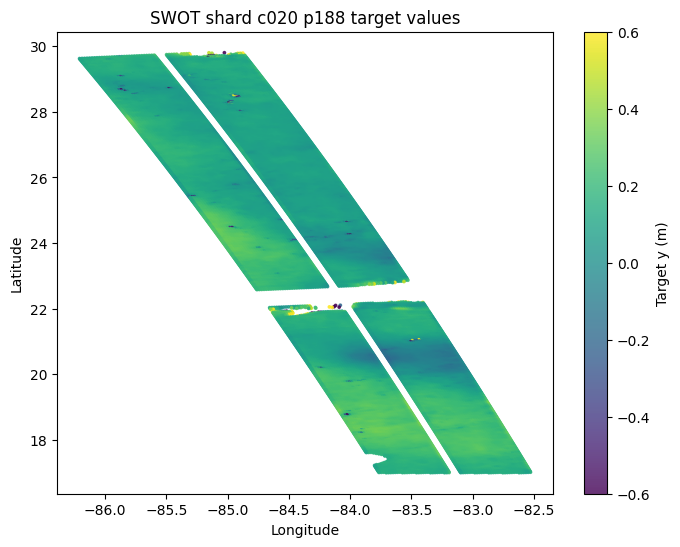

In [ ]:


shard_path = PROJECT_ROOT / "data" / "shards" / "swot_only_ssha" / "whole_shards" / "shard_c020_p188_SWOT_L2_LR_SSH_Expert_020_188_20240827T081052_20240827T090220_PIC0_01.npz"
if not shard_path.exists():
    raise FileNotFoundError(f"Shard not found at {shard_path}")

with np.load(shard_path) as shard:
    lon = shard["lon"]
    lat = shard["lat"]
    y = shard["y"]

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(lon, lat, c=y, s=3, cmap="viridis", vmin=-0.6, vmax=0.6, alpha=0.8)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("SWOT shard c020 p188 target values")
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Target y (m)")
plt.show()

In [41]:
cycle_20_pass_173 = inspect_pass_dataset(20, 175, preview_rows=8)


=== Cycle 20, Pass 175 ===
Dimensions: FrozenMappingWarningOnValuesAccess({'num_lines': 9866, 'num_pixels': 69, 'num_sides': 2})
Data variables (first 10): ['time', 'time_tai', 'ssh_karin', 'ssh_karin_qual', 'ssh_karin_uncert', 'ssha_karin', 'ssha_karin_qual', 'ssh_karin_2', 'ssh_karin_2_qual', 'ssha_karin_2']
Coordinates: ['latitude', 'longitude', 'latitude_nadir', 'longitude_nadir']
Time range: 2024-08-26T21:02:03.167288320 -> 2024-08-26T21:53:31.516817920
Attributes keys: ['Conventions', 'title', 'institution', 'source', 'history', 'platform', 'reference_document', 'contact', 'cycle_number', 'pass_number', 'equator_time', 'short_name', 'product_file_id', 'crid', 'product_version', 'pge_name', 'pge_version', 'time_coverage_start', 'time_coverage_end', 'geospatial_lon_min', 'geospatial_lon_max', 'geospatial_lat_min', 'geospatial_lat_max', 'left_first_longitude', 'left_first_latitude', 'left_last_longitude', 'left_last_latitude', 'right_first_longitude', 'right_first_latitude', 'right

,num_lines,num_pixels,num_sides,time,time_tai,latitude,longitude,ssh_karin,ssh_karin_qual,ssh_karin_uncert,...,rain_rate,ice_conc,sea_state_bias_cor,sea_state_bias_cor_2,swh_ssb_cor_source,swh_ssb_cor_source_2,wind_speed_ssb_cor_source,wind_speed_ssb_cor_source_2,volumetric_correlation,volumetric_correlation_uncert
0,0,0,0,2024-08-26 21:02:03.167288320,2024-08-26 21:02:40.167287808,-77.053701,184.003321,NaN,4.160783e+09,NaN,...,0.0,90.76,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0,0,1,2024-08-26 21:02:03.167288320,2024-08-26 21:02:40.167287808,-77.053701,184.003321,NaN,4.160783e+09,NaN,...,0.0,90.76,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,0,1,0,2024-08-26 21:02:03.167288320,2024-08-26 21:02:40.167287808,-77.071617,184.003062,NaN,4.160783e+09,NaN,...,0.0,90.54,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,0,1,1,2024-08-26 21:02:03.167288320,2024-08-26 21:02:40.167287808,-77.071617,184.003062,NaN,4.160783e+09,NaN,...,0.0,90.54,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,0,2,0,2024-08-26 21:02:03.167288320,2024-08-26 21:02:40.167287808,-77.089532,184.002802,NaN,3.623912e+09,0.0384,...,0.0,90.39,0.0,0.0,0.0,0.0,0.0,4.0,1.0216,0.10
5,0,2,1,2024-08-26 21:02:03.167288320,2024-08-26 21:02:40.167287808,-77.089532,184.002802,NaN,3.623912e+09,0.0384,...,0.0,90.39,0.0,0.0,0.0,0.0,0.0,4.0,1.0216,0.10
6,0,3,0,2024-08-26 21:02:03.167288320,2024-08-26 21:02:40.167287808,-77.107447,184.002542,NaN,3.623912e+09,0.0175,...,0.0,90.39,0.0,0.0,0.0,0.0,0.0,4.0,1.0155,0.05
7,0,3,1,2024-08-26 21:02:03.167288320,2024-08-26 21:02:40.167287808,-77.107447,184.002542,NaN,3.623912e+09,0.0175,...,0.0,90.39,0.0,0.0,0.0,0.0,0.0,4.0,1.0155,0.05


In [ ]:

bbox = {"min_lon": -99, "min_lat": 17, "max_lon": -79, "max_lat": 31}

def subset_ds_to_bbox(ds: xr.Dataset, bbox: dict) -> xr.Dataset:
    if ds is None:
        print("No dataset provided.")
        return ds

    lat = ds["latitude"]
    lon = ds["longitude"]

    lon_min_ds = float(lon.min().values)
    lon_max_ds = float(lon.max().values)
    print(f"Dataset lon range: {lon_min_ds:.3f} -> {lon_max_ds:.3f}")

    bb = bbox.copy()

    if lon_min_ds >= 0 and (bb["min_lon"] < -180 or bb["max_lon"] < 0):
        bb["min_lon"] = bb["min_lon"] % 360
        bb["max_lon"] = bb["max_lon"] % 360
        print(f"Converted bbox lon to 0-360: {bb['min_lon']} -> {bb['max_lon']}")

    lat_mask = (lat >= bb["min_lat"]) & (lat <= bb["max_lat"])
    if bb["min_lon"] <= bb["max_lon"]:
        lon_mask = (lon >= bb["min_lon"]) & (lon <= bb["max_lon"])
    else:
        lon_mask = (lon >= bb["min_lon"]) | (lon <= bb["max_lon"])

    mask = lat_mask & lon_mask

    ds_sub = ds.where(mask, drop=True)
    print("Subset dims:", ds_sub.dims)
    return ds_sub


ds_bbox = subset_ds_to_bbox(cycle_20_pass_173, bbox)
if ds_bbox is not None:
    df_bbox = ds_bbox.to_dataframe().reset_index().dropna(subset=["latitude", "longitude"])
    print("Rows in bbox dataframe:", len(df_bbox))
    display(df_bbox.head())


Dataset lon range: 183.984 -> 351.428
Converted bbox lon to 0-360: 261 -> 281
Subset dims: FrozenMappingWarningOnValuesAccess({'num_lines': 800, 'num_pixels': 69, 'num_sides': 2})
Rows in bbox dataframe: 110400


,num_lines,num_pixels,num_sides,time,time_tai,ssh_karin,ssh_karin_qual,ssh_karin_uncert,ssha_karin,ssha_karin_qual,...,swh_ssb_cor_source,swh_ssb_cor_source_2,wind_speed_ssb_cor_source,wind_speed_ssb_cor_source_2,volumetric_correlation,volumetric_correlation_uncert,latitude,longitude,latitude_nadir,longitude_nadir
0,0,0,0,2024-08-26 21:32:44.706642944,2024-08-26 21:33:21.706642048,NaN,4.160783e+09,NaN,NaN,4.160783e+09,...,0.0,0.0,0.0,0.0,NaN,NaN,17.001135,269.648202,16.905186,270.278161
1,0,0,1,2024-08-26 21:32:44.706642944,2024-08-26 21:33:21.706642048,NaN,4.160783e+09,NaN,NaN,4.160783e+09,...,0.0,0.0,0.0,0.0,NaN,NaN,17.001135,269.648202,16.905186,270.278161
2,0,1,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,16.998340,269.666758,16.905186,270.278161
3,0,1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,16.998340,269.666758,16.905186,270.278161
4,0,2,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,16.995544,269.685314,16.905186,270.278161


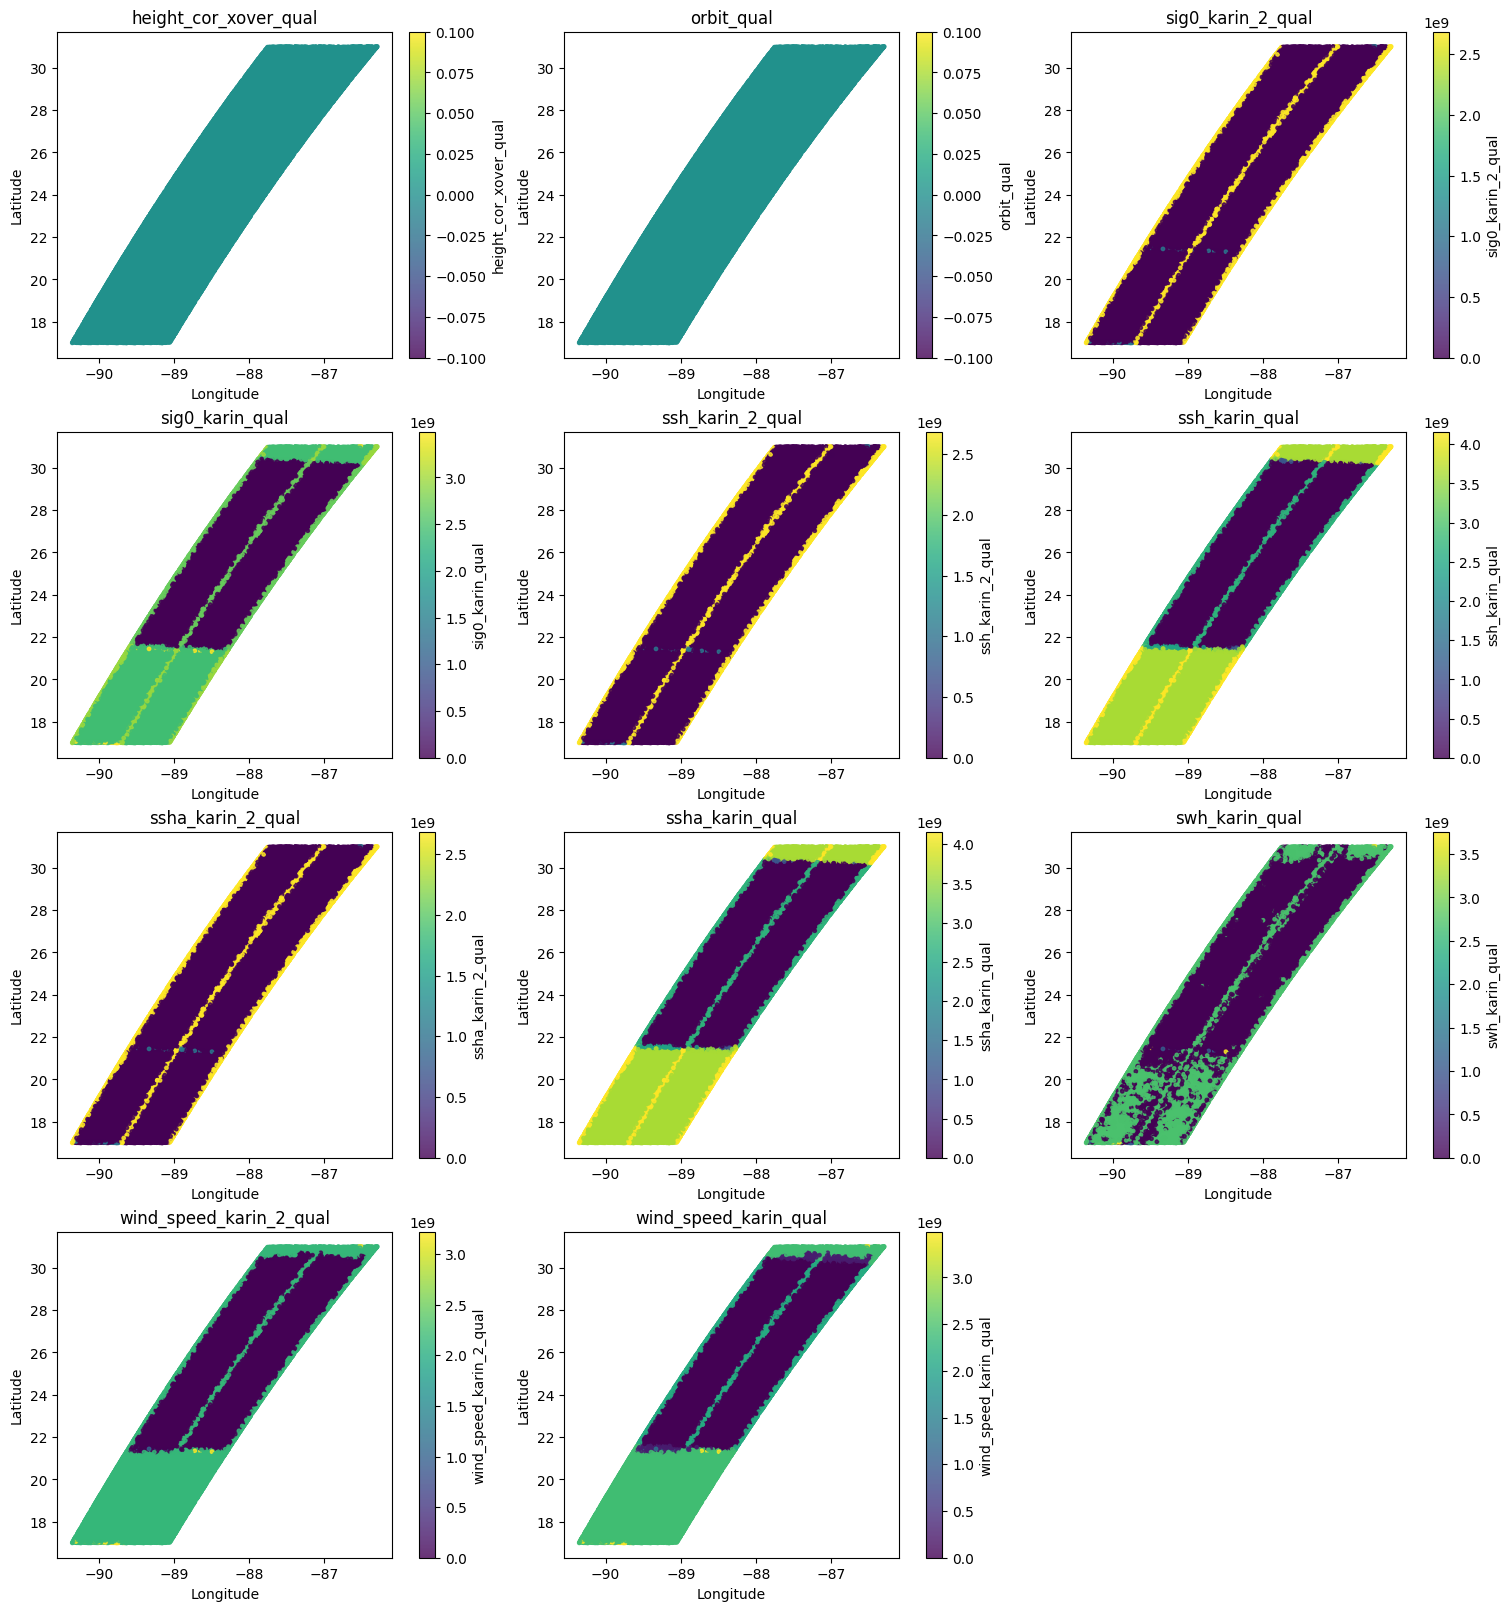

In [ ]:
qual_vars_found = sorted({c for c in df_bbox.columns if c.endswith("_qual") or "_qual" in c})
if not qual_vars_found:
    raise RuntimeError("No _qual variables found in df_bbox")
vars_to_plot = [v for v in qual_vars_found if v in df_bbox.columns]
if not vars_to_plot:
    raise RuntimeError("No _qual variables found in df_bbox")

df_plot = df_bbox.copy()
df_plot["plot_lon"] = np.where(df_plot["longitude"] > 180, df_plot["longitude"] - 360, df_plot["longitude"])

n = len(vars_to_plot)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), constrained_layout=True)
axes = axes.ravel()

for ax, name in zip(axes, vars_to_plot):
    sub = df_plot.dropna(subset=["latitude", "plot_lon", name])
    if sub.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])
        continue


    max_points = 50000
    if len(sub) > max_points:
        sub = sub.sample(max_points, random_state=0)

    sc = ax.scatter(sub["plot_lon"], sub["latitude"], c=sub[name], s=6, cmap="viridis", alpha=0.8)
    ax.set_title(name)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.colorbar(sc, ax=ax, label=name)


for ax in axes[len(vars_to_plot):]:
    ax.axis("off")

plt.show()

In [ ]:

qual_vars_found = sorted({c for c in df_bbox.columns if c.endswith("_qual") or "xover" in c})
if not qual_vars_found:
    raise RuntimeError("No _qual variables found in df_bbox")

In [47]:
qual_vars_found

['height_cor_xover',
 'height_cor_xover_qual',
 'orbit_qual',
 'sig0_karin_2_qual',
 'sig0_karin_qual',
 'ssh_karin_2_qual',
 'ssh_karin_qual',
 'ssha_karin_2_qual',
 'ssha_karin_qual',
 'swh_karin_qual',
 'wind_speed_karin_2_qual',
 'wind_speed_karin_qual']

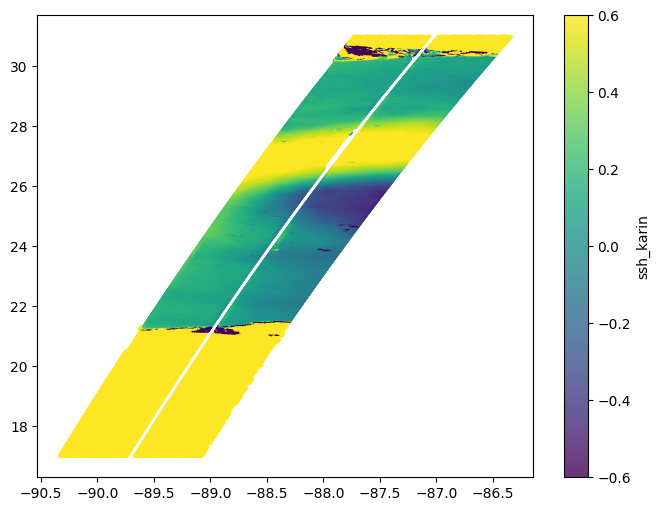

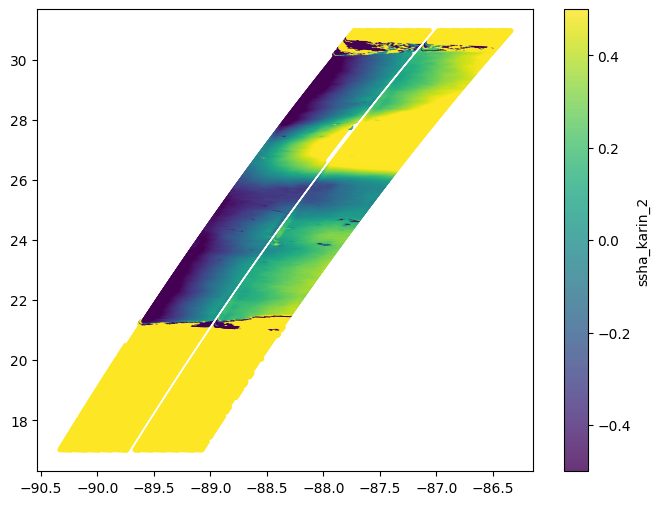

In [61]:
df_plot = df_bbox.copy()
df_plot["plot_lon"] = np.where(df_plot["longitude"] > 180, df_plot["longitude"] - 360, df_plot["longitude"])

plt.figure(figsize=(8, 6))
sc = plt.scatter(df_plot["plot_lon"], df_plot["latitude"], c=df_plot["ssha_karin_2"] + df_plot["height_cor_xover"], s=3, cmap="viridis", alpha=0.8,vmin=-0.6,vmax=0.6)
plt.colorbar(sc, label="ssh_karin")
plt.show()

plt.figure  (figsize=(8, 6))
sc = plt.scatter(df_plot["plot_lon"], df_plot["latitude"], c=df_plot["ssha_karin_2"], s=6, cmap="viridis", alpha=0.8,vmin=-0.5,vmax=0.5)
plt.colorbar(sc, label="ssha_karin_2")
plt.show()

# 4. Inspect Raw Data for Cycle 20 Pass 203
Repeat the inspection for the other descending/ascending partner in Cycle 20.

In [25]:
cycle_20_pass_203 = inspect_pass_dataset(20, 203, preview_rows=8)

if cycle_20_pass_203 is not None:
    print("Variables summary for cycle 20 pass 203:")
    display(pd.DataFrame({
        "dims": cycle_20_pass_203.dims,
    }.items(), columns=["key", "value"]))

Found 1 granules for cycle 20, pass 203

=== Cycle 20, Pass 203 ===
Dimensions: FrozenMappingWarningOnValuesAccess({'num_lines': 9866, 'num_pixels': 69, 'num_sides': 2})
Data variables (first 10): ['time', 'time_tai', 'ssh_karin', 'ssh_karin_qual', 'ssh_karin_uncert', 'ssha_karin', 'ssha_karin_qual', 'ssh_karin_2', 'ssh_karin_2_qual', 'ssha_karin_2']
Coordinates: ['latitude', 'longitude', 'latitude_nadir', 'longitude_nadir']
Time range: 2024-08-27T21:02:34.477434240 -> 2024-08-27T21:54:02.839137536
Attributes keys: ['Conventions', 'title', 'institution', 'source', 'history', 'platform', 'reference_document', 'contact', 'cycle_number', 'pass_number', 'equator_time', 'short_name', 'product_file_id', 'crid', 'product_version', 'pge_name', 'pge_version', 'time_coverage_start', 'time_coverage_end', 'geospatial_lon_min', 'geospatial_lon_max', 'geospatial_lat_min', 'geospatial_lat_max', 'left_first_longitude', 'left_first_latitude', 'left_last_longitude', 'left_last_latitude', 'right_first_lo

,num_lines,num_pixels,num_sides,time,time_tai,latitude,longitude,ssh_karin,ssh_karin_qual,ssh_karin_uncert,...,rain_rate,ice_conc,sea_state_bias_cor,sea_state_bias_cor_2,swh_ssb_cor_source,swh_ssb_cor_source_2,wind_speed_ssb_cor_source,wind_speed_ssb_cor_source_2,volumetric_correlation,volumetric_correlation_uncert
0,0,0,0,2024-08-27 21:02:34.477434240,2024-08-27 21:03:11.477435136,-77.053701,181.537567,NaN,4.160783e+09,NaN,...,0.0,90.49,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0,0,1,2024-08-27 21:02:34.477434240,2024-08-27 21:03:11.477435136,-77.053701,181.537567,NaN,4.160783e+09,NaN,...,0.0,90.49,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,0,1,0,2024-08-27 21:02:34.477434240,2024-08-27 21:03:11.477435136,-77.071617,181.537309,NaN,4.160783e+09,NaN,...,0.0,90.42,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,0,1,1,2024-08-27 21:02:34.477434240,2024-08-27 21:03:11.477435136,-77.071617,181.537309,NaN,4.160783e+09,NaN,...,0.0,90.42,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,0,2,0,2024-08-27 21:02:34.477434240,2024-08-27 21:03:11.477435136,-77.089532,181.537049,NaN,3.624567e+09,0.0561,...,0.0,90.37,0.0,0.0,0.0,0.0,0.0,4.0,1.0550,0.08
5,0,2,1,2024-08-27 21:02:34.477434240,2024-08-27 21:03:11.477435136,-77.089532,181.537049,NaN,3.624567e+09,0.0561,...,0.0,90.37,0.0,0.0,0.0,0.0,0.0,4.0,1.0550,0.08
6,0,3,0,2024-08-27 21:02:34.477434240,2024-08-27 21:03:11.477435136,-77.107447,181.536789,NaN,3.624567e+09,0.0292,...,0.0,90.35,0.0,0.0,0.0,0.0,0.0,4.0,1.0673,0.05
7,0,3,1,2024-08-27 21:02:34.477434240,2024-08-27 21:03:11.477435136,-77.107447,181.536789,NaN,3.624567e+09,0.0292,...,0.0,90.35,0.0,0.0,0.0,0.0,0.0,4.0,1.0673,0.05


Variables summary for cycle 20 pass 203:


,key,value
0,dims,"(num_lines, num_pixels, num_sides)"


# 6. Inspect Raw Data for Cycle 21 Pass 203
Complete the set by examining the counterpart pass for Cycle 21.

In [ ]:
cycle_21_pass_203 = inspect_pass_dataset(21, 203, preview_rows=8)

if cycle_21_pass_203 is not None:
    numeric_vars = [name for name, da in cycle_21_pass_203.data_vars.items() if np.issubdtype(da.dtype, np.number)]
    summary_stats = {
        name: cycle_21_pass_203[name].to_series().describe().to_dict()
        for name in numeric_vars[:3]
    }
    display(pd.DataFrame(summary_stats))

Found 1 granules for cycle 21, pass 203

=== Cycle 21, Pass 203 ===
Dimensions: FrozenMappingWarningOnValuesAccess({'num_lines': 9866, 'num_pixels': 69, 'num_sides': 2})
Data variables (first 10): ['time', 'time_tai', 'ssh_karin', 'ssh_karin_qual', 'ssh_karin_uncert', 'ssha_karin', 'ssha_karin_qual', 'ssh_karin_2', 'ssh_karin_2_qual', 'ssha_karin_2']
Coordinates: ['latitude', 'longitude', 'latitude_nadir', 'longitude_nadir']
Time range: 2024-09-17T17:47:40.891120384 -> 2024-09-17T18:39:09.174561152
Attributes keys: ['Conventions', 'title', 'institution', 'source', 'history', 'platform', 'reference_document', 'contact', 'cycle_number', 'pass_number', 'equator_time', 'short_name', 'product_file_id', 'crid', 'product_version', 'pge_name', 'pge_version', 'time_coverage_start', 'time_coverage_end', 'geospatial_lon_min', 'geospatial_lon_max', 'geospatial_lat_min', 'geospatial_lat_max', 'left_first_longitude', 'left_first_latitude', 'left_last_longitude', 'left_last_latitude', 'right_first_lo

,num_lines,num_pixels,num_sides,time,time_tai,latitude,longitude,ssh_karin,ssh_karin_qual,ssh_karin_uncert,...,rain_rate,ice_conc,sea_state_bias_cor,sea_state_bias_cor_2,swh_ssb_cor_source,swh_ssb_cor_source_2,wind_speed_ssb_cor_source,wind_speed_ssb_cor_source_2,volumetric_correlation,volumetric_correlation_uncert
0,0,0,0,2024-09-17 17:47:40.891120384,2024-09-17 17:48:17.891120512,-77.053701,181.537567,NaN,4.160783e+09,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0,0,1,2024-09-17 17:47:40.891120384,2024-09-17 17:48:17.891120512,-77.053701,181.537567,NaN,4.160783e+09,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,0,1,0,2024-09-17 17:47:40.891120384,2024-09-17 17:48:17.891120512,-77.071617,181.537309,NaN,4.160783e+09,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,0,1,1,2024-09-17 17:47:40.891120384,2024-09-17 17:48:17.891120512,-77.071617,181.537309,NaN,4.160783e+09,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,0,2,0,2024-09-17 17:47:40.891120384,2024-09-17 17:48:17.891120512,-77.089532,181.537049,NaN,3.623912e+09,0.1080,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,4.0,1.1046,0.15
5,0,2,1,2024-09-17 17:47:40.891120384,2024-09-17 17:48:17.891120512,-77.089532,181.537049,NaN,3.623912e+09,0.1080,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,4.0,1.1046,0.15
6,0,3,0,2024-09-17 17:47:40.891120384,2024-09-17 17:48:17.891120512,-77.107447,181.536789,NaN,3.623912e+09,0.0496,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,4.0,1.0873,0.07
7,0,3,1,2024-09-17 17:47:40.891120384,2024-09-17 17:48:17.891120512,-77.107447,181.536789,NaN,3.623912e+09,0.0496,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,4.0,1.0873,0.07


,ssh_karin,ssh_karin_qual,ssh_karin_uncert
count,393800.000000,6.807540e+05,611380.000000
mean,-13.219388,1.673511e+09,0.017473
std,18.427625,1.767750e+09,0.061260
min,-81.731800,0.000000e+00,0.000000
25%,-22.311375,0.000000e+00,0.002500
50%,-9.101300,2.560000e+02,0.003400
75%,-4.646875,3.623912e+09,0.008100
max,160.718300,4.160783e+09,6.394400
